In [6]:
#Fill the paths below
PATH_FRC = "" # git repo directory path
KADIK = "" # data from http://database.mmsp-kn.de/kadid-10k-database.html 
PATH_ZENODO = "" # Data and models are available here: https://zenodo.org/record/5831014#.YdnW_VjMLeo
GAUSS_L2_MODEL = PATH_ZENODO+'/models/gaussian/noise04/l2/'

In [2]:
import sys
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

import math
from skimage.io import imread
from skimage.filters import window
sys.path.append(PATH_FRC)
from models2 import FRCUnetModel

import matplotlib
import tensorflow as tf

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})

In [8]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def read_image(file, windowing=True):
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = tf.convert_to_tensor(clean)
    clean = clean[tf.newaxis, ..., tf.newaxis]
    clean = tf.image.resize(
        clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True, \
        antialias=False, name=None)
    clean=clean.numpy().squeeze()
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    if windowing:
        clean = clean*window('hann', clean.shape) 
    return clean

def read_in_distortion(image_number, distortion, windowing=True, path=KADIK):
    # reads in all levels (5)
    distortions = np.zeros((6, 256, 256))
    for i in glob.glob(path+'/I'+image_number+'_'+distortion+'*.png'):
        level = int(os.path.basename(i)[-6:-4])
        distortions[level] = read_image(i, windowing)
    distortions[0] = read_image(path+'/I'+image_number+'.png', windowing)
    return distortions

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))

def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    return frc  

In [4]:
l2_model=load_model(GAUSS_L2_MODEL, 'saved-model-epoch-200')
rm = l2_model.radial_masks
sf = l2_model.spatial_freq

In [9]:
gaussian = read_in_distortion('20', '11')
impulse = read_in_distortion('20', '13')
jitter = read_in_distortion('20', '19')
blur = read_in_distortion('20', '03')

In [10]:
gaussian_frc=[]
for i in range(5):
    frc = fourier_ring_correlation_by_ring(np.reshape(gaussian[0], [1,256, 256,1]), np.reshape(gaussian[i+1],\
                                        [1,256, 256,1]), rm, sf)
    gaussian_frc.append(frc)
    
impulse_frc=[]
for i in range(5):
    frc = fourier_ring_correlation_by_ring(np.reshape(impulse[0], [1,256, 256,1]), np.reshape(impulse[i+1],\
                                        [1,256, 256,1]), rm, sf)
    impulse_frc.append(frc)
    
jitter_frc=[]
for i in range(5):
    frc = fourier_ring_correlation_by_ring(np.reshape(jitter[0], [1,256, 256,1]), np.reshape(jitter[i+1],\
                                        [1,256, 256,1]), rm, sf)
    jitter_frc.append(frc)

blur_frc=[]
for i in range(5):
    frc = fourier_ring_correlation_by_ring(np.reshape(blur[0], [1,256, 256,1]), np.reshape(blur[i+1],\
                                        [1,256, 256,1]), rm, sf)
    blur_frc.append(frc)   

In [11]:
#again, to not show windowing in the image below
gaussian = read_in_distortion('20', '11',windowing=False)
impulse = read_in_distortion('20', '13',windowing=False)
jitter = read_in_distortion('20', '19',windowing=False)
blur = read_in_distortion('20', '03',windowing=False)

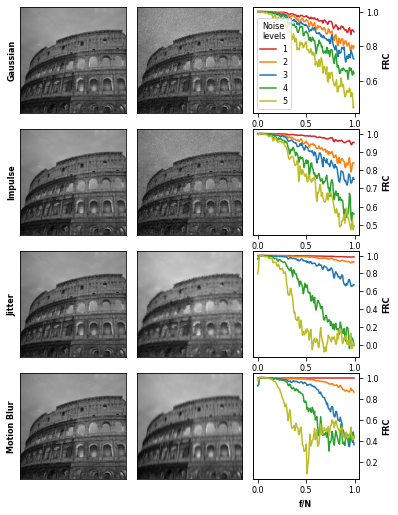

In [12]:
fig = plt.figure()
 fig.set_size_inches(5.6, 7.2)

x=np.arange(len(gaussian_frc[0].numpy().T[0]))*1.0/len(gaussian_frc[0].numpy().T[0])

ax = fig.add_subplot(431)
ax.imshow(gaussian[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.ylabel('Gaussian')
ax = fig.add_subplot(432)
ax.imshow(gaussian[5], cmap='gray')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(433)
plt.yticks([])
ax2 = ax.twinx()
ax2.set_ylabel('FRC')
ax2.plot(x,gaussian_frc[0].numpy().T[0],label='1', color= 'tab:red')
ax2.plot(x,gaussian_frc[1].numpy().T[0],label='2', color=  'tab:orange')
ax2.plot(x,gaussian_frc[2].numpy().T[0],label='3', color=  'tab:blue')
ax2.plot(x,gaussian_frc[3].numpy().T[0],label='4', color=  'tab:green')
ax2.plot(x,gaussian_frc[4].numpy().T[0],label='5', color=  'tab:olive')
plt.legend(title='Noise\nlevels')

ax = fig.add_subplot(434)
ax.imshow(impulse[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.ylabel('Impulse')
ax = fig.add_subplot(435)
ax.imshow(impulse[5], cmap='gray')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(436)
plt.yticks([])
ax2 = ax.twinx()
ax2.set_ylabel('FRC')
ax2.plot(x,impulse_frc[0].numpy().T[0],label='1', color= 'tab:red')
ax2.plot(x,impulse_frc[1].numpy().T[0],label='2', color=  'tab:orange')
ax2.plot(x,impulse_frc[2].numpy().T[0],label='3', color=  'tab:blue')
ax2.plot(x,impulse_frc[3].numpy().T[0],label='4', color=  'tab:green')
ax2.plot(x,impulse_frc[4].numpy().T[0],label='5', color=  'tab:olive')


ax = fig.add_subplot(437)
ax.imshow(jitter[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.ylabel('Jitter')
ax = fig.add_subplot(438)
ax.imshow(jitter[5], cmap='gray')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(439)
plt.yticks([])
ax2 = ax.twinx()
ax2.set_ylabel('FRC')
ax2.plot(x,jitter_frc[0].numpy().T[0],label='1', color= 'tab:red')
ax2.plot(x,jitter_frc[1].numpy().T[0],label='2', color=  'tab:orange')
ax2.plot(x,jitter_frc[2].numpy().T[0],label='3', color=  'tab:blue')
ax2.plot(x,jitter_frc[3].numpy().T[0],label='4', color=  'tab:green')
ax2.plot(x,jitter_frc[4].numpy().T[0],label='5', color=  'tab:olive')

ax = fig.add_subplot(4,3,10)
ax.imshow(blur[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.ylabel('Motion Blur')
ax = fig.add_subplot(4,3,11)
ax.imshow(blur[5], cmap='gray')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(4,3,12)
ax.yaxis.set_ticks_position('none') 
plt.yticks([])
ax2 = ax.twinx()
ax2.set_ylabel('FRC')
ax.set_xlabel('f/N')
ax2.plot(x,blur_frc[0].numpy().T[0],label='1', color= 'tab:red')
ax2.plot(x,blur_frc[1].numpy().T[0],label='2', color=  'tab:orange')
ax2.plot(x,blur_frc[2].numpy().T[0],label='3', color=  'tab:blue')
ax2.plot(x,blur_frc[3].numpy().T[0],label='4', color=  'tab:green')
ax2.plot(x,blur_frc[4].numpy().T[0],label='5', color=  'tab:olive')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.15)
fig.savefig('figure_s1.png', dpi=300)